In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
from astropy.io import fits
import warnings
from scipy import optimize
# import muse_tools as mt
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from telassar import PVSlice
import astropy.units as u

In [3]:
def gauss2D(amp, x0, y0, xsig, ysig):
    return lambda x, y: amp * np.exp(-(((x0 - x)/xsig)**2 +
                                       ((y0 - y)/ysig)**2)/2)

def moments(data):
    total = np.abs(data).sum()
    Y, X = np.indices(data.shape)
    y = np.argmax((X * np.abs(data)).sum(axis = 1) / total)
    x = np.argmax((Y * np.abs(data)).sum(axis = 0) /total)
    col = data[int(y), :]
    row = data[:, int(x)]
    xwidth = np.sqrt(np.abs((np.arange(col.size) - y)*col).sum() / 
                     np.abs(col).sum())
    ywidth = np.sqrt(np.abs((np.arange(row.size) - x)*row).sum() /
                     np.abs(row).sum())
    height = data.max()
    mom = np.array([ywidth, xwidth])
    return height, y, x, ywidth, xwidth

def fitgauss(data):
    params = (moments(data))
    errorfunction = lambda p: np.ravel(gauss2D(*p)(*np.indices(data.shape)) - data)
    p, success = optimize.leastsq(errorfunction, x0 = params)
    return p

<IPython.core.display.Javascript object>


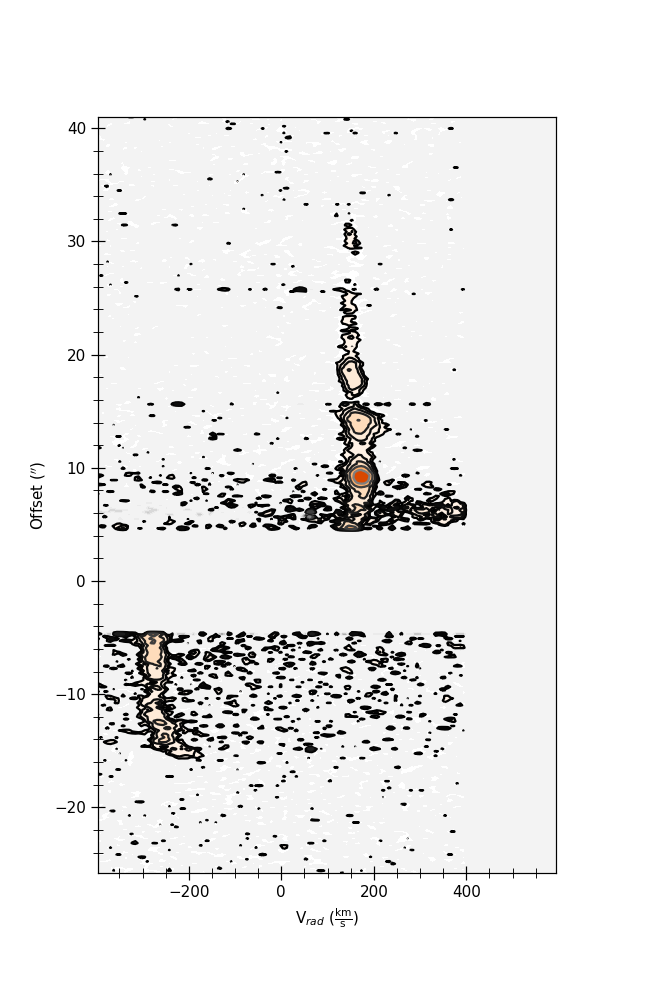

In [6]:
%matplotlib notebook 
xsho = PVSlice('data/HD163296_SIIF_6730.fits')
xsho.plot_contours()

<IPython.core.display.Javascript object>


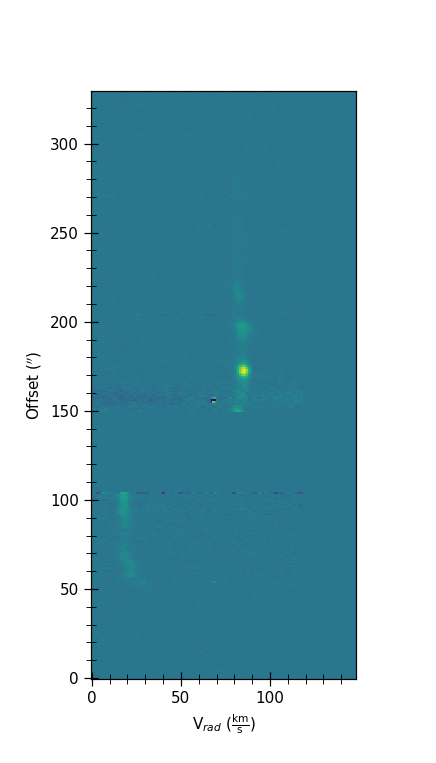

In [95]:
from matplotlib.ticker import AutoMinorLocator

def configure_axes(ax, obj):
        
    labels = {
        'OFFSET' : 'Offset',
        'VELO' : 'V$_{rad}$', 
        'WAVE' : '$\lambda$',
        'AWAV' : '$\lambda$'
    }

    spec = obj.velwave
    pos = obj.position

    spec_type = spec.wcs.wcs.ctype[0]
    spat_type = pos.wcs.wcs.ctype[0]

    y_type = labels[spat_type] if spat_type in labels.keys() else ''
    x_type = labels[spec_type] if spec_type in labels.keys() else ''
    
    ax.set_xlabel(rf'{x_type} ({u.Unit(spec.unit).to_string("latex")})')
    ax.set_ylabel(rf'{y_type} ({u.Unit(pos.unit).to_string("latex")})')
    
    ax.margins(0.05)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which = 'major', direction = 'inout', length = 9)
    ax.tick_params(which = 'minor', direction = 'inout', length = 6)

    
fig, ax = plt.subplots(figsize = (4, 7))

ax.imshow(xsho._data, origin = 'lower')

configure_axes(ax, xsho)

<IPython.core.display.Javascript object>


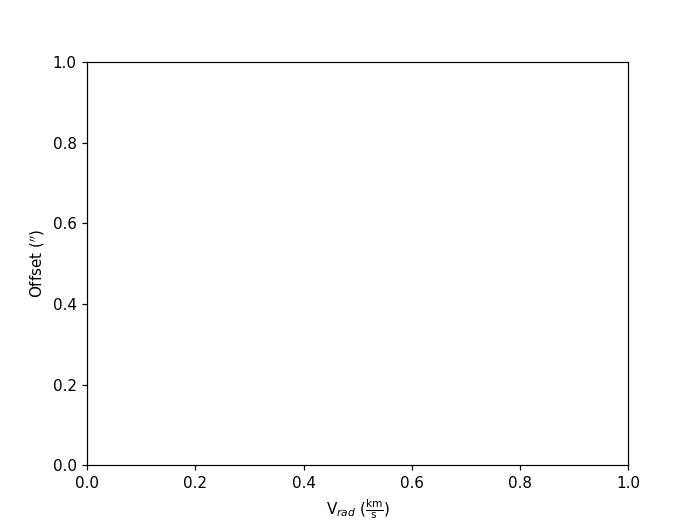

V$_{rad}$ ($\mathrm{\frac{km}{s}}$)


In [85]:
from matplotlib.ticker import AutoMinorLocator

class Contours(Figure):
    
    #def __init__(self, PVSlice, title = '', xlabel = None, ylabel = None,
    #            **kwargs):
    
    def __init__(self, PVSlice, title = None, xlabel = None, 
                 ylabel = None, **kwargs):
        
        super().__init__(**kwargs)    
        
        #self.figure = None
        #self.axis = None
        self.axis = None
        self.PVSlice = PVSlice
        #self._toggle_unit = toggle_unit
        self._xunit = u.Unit(self.PVSlice.velwave.unit).to_string('latex')
        self._yunit = u.Unit(self.PVSlice.position.unit).to_string('latex')
        self.title = title
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.plotkwargs = kwargs
        self._xlim = [None, None]
        self._ylim = [None, None]
        self.offset = 0.

    def configure_axes(self, ax):
        
        labels = {
            'OFFSET' : rf'Offset',
            'VELO' : r'V$_{rad}$', 
            'WAVE' : r'$\lambda$',
            'AWAV' : r'$\lambda$'
        }
    
        self.axis = ax
        spec = self.PVSlice.velwave
        pos = self.PVSlice.position
        
        spec_type = spec.wcs.wcs.ctype[0]
        spat_type = pos.wcs.wcs.ctype[0]
    
        y_type = labels[spat_type] if spat_type in labels.keys() else ''
        x_type = labels[spec_type] if spec_type in labels.keys() else ''
        
        self.xlabel = rf'{x_type} ({self._xunit})'
        self.ylabel = rf'{y_type} ({self._yunit})'
        self.axis.set_xlabel(self.xlabel)
        self.axis.set_ylabel(self.ylabel)
        
        
        
        
fig, ax = plt.subplots(FigureClass = Contours, PVSlice = xsho)

fig.configure_axes(ax)
print(fig.xlabel)

In [26]:
def plot_contours(self, sig = None, mask = None, levels1 = None, levels2 = None,
                      cmaps = None, ax_kws = None, fig_kws = None, emline = None):

        if ax_kws is None:
            ax_kws = {}
        if fig_kws is None:
            fig_kws = {'figsize' : (6, 9)}

        emis = None
        if emline is not None:
            if emline in lines.keys():
                emis = lines[emline][2]
                ax_kws.update({'title': rf'{emis}'})

        # default cmap colors
        colors = ['gist_gray', 'Oranges', 'gray']
        data = self.data.copy()
        # generate a sigma based on the data?
        sig = get_background_rms(data, sigma=3., N=10, mask=None)


        if (levels1 is None) or (levels2 is None):
            lvls1, lvls2 = get_contour_levels(data, sig)

        levels1 = levels1 if levels1 is not None else lvls1
        levels2 = levels2 if levels2 is not None else lvls2

        cmaps = colors if cmaps is None else cmaps

        extent = get_plot_extent(self.position, self.velwave)

        spectral_unit = u.Unit(self.velwave.unit).to_string('latex')
        spatial_unit = u.Unit(self.position.unit).to_string('latex')
        if self.position.wcs.wcs.ctype[0] == 'OFFSET':
            y_type = rf'Offset'
        else:
            y_type = ''
        if self.velwave.wcs.wcs.ctype[0] == 'VELO':
            x_type = r'V$_{rad}$'
        elif self.velwave.wcs.wcs.ctype[0] in ['WAVE', 'AWAV']:
            x_type = r'$\lambda$'
        else:
            x_type = ''

        # testing this
        ax_kws.update({'xlabel' : rf'{x_type} ({spectral_unit})',
                       'ylabel' : rf'{y_type} ({spatial_unit})'})

        fig, ax = plt.subplots(**fig_kws, subplot_kw = ax_kws)
        jet1 = ax.contour(data, levels=levels1, cmap=cmaps[0], extent=extent)
        jet2 = ax.contourf(data, levels=levels1, cmap=cmaps[1], extent=extent)
        bkgrd = ax.contourf(data, levels=levels2, cmap=cmaps[2], extent=extent,
                            alpha = 0.8)

        ax.margins(0.05)
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(which = 'major', direction = 'inout', length = 9)
        ax.tick_params(which = 'minor', direction = 'inout', length = 6)


        # format the coordinates
        toggle_unit = True if extent is not None else False
        ax.format_coord = ImCoords(self, data, toggle_unit)
        fig.subplots_adjust(left = 0.15, right = 0.85)

        return ax


In [28]:
%matplotlib notebook

test = ContourPlotter(xsho)